# Estudo de caso de um reator de pesquisa com Elemento combustível (EC) tipo placa. Projeto termo-hidráulico do núcleo de um reator a partir do canal do EC de maior potência.  

In [ ]:
!pip install CoolProp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 49.7 MB/s eta 0:00:00


In [ ]:
#Importando as bibliotecas

import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from sympy import *
import CoolProp.CoolProp as CP
init_printing(pretty_print=true)

# Dados do problema:

![picture](https://drive.google.com/uc?id=1ZIp10JHfQ2VxvaLPKm9GCTur85KBcLHh)

In [ ]:
P_reator =  5*10**6 # [W]. Potência do reator em W.
N_EC = 24 # Número de Elementos combustíveis (EC)
Q_max_EC = 1.914
q_prime_EC = (Q_max_EC*P_reator)/N_EC # EC com a máxima taxa de transferência de calor
N_placas = N_canais = 18
q_prime_medio = q_prime_EC/N_placas # [W/placa]
L_placa = 600/1000 # [m] Comprimento do combustível na placa
W_placa = 62.6/1000 # [m] Largura do combustível na placa
A_placa = L_placa * W_placa
q_prime_max = q_prime_medio/A_placa # [W/m²] Fluxo de calor máximo na placa do EC com a maior taxa de transferência de calor.
dcomb = (1.52-2*0.38)/2000 # [m] distância do centro do combustível até o revestimento
drev = 0.38/1000 #[m] espessura do revestimento (*cladding*)
Ny = 600 # Número de camadas na direção y. Vamos variar esse parêmetro em V 6, 12, 60, 120, 600 para ver sua influencia nos resultados.
dy = L_placa/Ny
L_canal = 67.1/1000 # [m]
e_canal = 2.89/1000 # [m] 
A_canal = L_canal*e_canal # [m²]
N_canal = 18 # Número de canais. 
V_EC = 22.8 # [m³/h] Vazão em um EC 
V_canal = V_EC / N_canal # [m³/h] Vazão em um canal
velocidade_canal = (V_canal / (A_canal*3600)) # [m/s]
T_inlet = 30 # °C. Temperatura na entrada do canal
P_inlet = 1.6e5 # [Pa] Pressão na entrada do canal
P_outlet = 1.7e5 # [Pa] Pressão na saída do canal
deltaP = (P_outlet - P_inlet)/Ny
P_fluido = P_inlet
kcomb = 10 # W/m.K condutividade do combustível. Inicialmente será considerada como um valor constante.
krev = 180 # W/m.K condutividade do revestimento (Alumínio).
fluido = 'water'
rho_inlet = CP.PropsSI('D', 'T', T_inlet + 273.15, 'P', P_inlet, fluido) # Densidade em [kg/m³]
cp = CP.PropsSI("CPMASS", "T", T_inlet + 273.15, 'P', P_inlet, fluido) # [J/Kg.K]
m_dot = velocidade_canal*A_canal*rho_inlet # Vazão mássica do fluido refrigerante em [m/s]
Dh = 2*(L_canal * e_canal) / (L_canal + e_canal) # [m]

# Definição das distâncias:

In [ ]:
Lcomb_rev = dcomb/2 + drev/2
Lcomb_i = dcomb/2
Lrev_i = drev/2
Lcanal_i = e_canal/2

# Definição das áreas:

In [ ]:
Ax = dy*W_placa
Aycomb = dcomb*W_placa
Ayrev = drev*W_placa
Aycanal = e_canal*W_placa

# Função para o cálculo do coeficiente de transferência de calor por convecção. Para determinação do número de Nusselt foi utilizada a correlação de *Dittus-Boelter*. 


```
 Nu = 0.023*Re**0.8 * Pr**0.4 # Dittus-Boelter correlation
```



In [ ]:
def calculate_convection_coefficient(T, P, fluido, Dh, v):
    # Cálculo das propriedades iniciais
    cp = CP.PropsSI('CPMASS', 'T', T + 273.15, 'P', P, fluido)  # Calor específico em J/kg·K
    mu = CP.PropsSI('VISCOSITY', 'T', T + 273.15, 'P', P, fluido)  # Viscosidade absoluta em Pa·s
    k = CP.PropsSI('conductivity','T', T + 273.15, 'P', P, fluido) # Condutividade térmica em W/m·K
    rho = CP.PropsSI('D', 'T', T + 273.15, 'P', P, fluido)  # Densidade em kg/m³

    # Inicialização do coeficiente de transferência de calor por convecção
    h = None

    # Iteração ao longo do canal
    for i in range(1, Ny-1):
        # Cálculo do número de Prandtl (Pr)
        Pr = (cp * mu) / k

        # Cálculo do número de Reynolds (Re)
        Re = (rho * v * Dh) / mu

        # Cálculo do coeficiente de transferência de calor por convecção (h)
        h = 0.023 * (k / Dh) * (Re ** 0.8) * (Pr ** 0.4)

    return h

h = calculate_convection_coefficient(T_inlet, P_inlet, fluido, Dh, velocidade_canal)
print("Coeficiente de transferência de calor por convecção (h):", h, "W/m².K")


Coeficiente de transferência de calor por convecção (h): 9536.674492729622 W/m².K


# Definição das condutâncias:

In [ ]:
Gcomb_i = kcomb*Ax/Lcomb_i # Condutância combustível-interface
Grev_i = krev*Ax/Lrev_i # Condutância revestimento-interface
Gcomb_rev = (Gcomb_i*Grev_i)/(Gcomb_i+Grev_i)
Grev_sup = (krev*Ax)/Lrev_i
Gcanal_sup = h*Ax
Gcanal = m_dot*cp
Gcomb = kcomb*Aycomb/dy
Grev = krev*Ayrev/dy

# Calculo do fluxo de calor ao longo do canal em um reator tipo placa
Para a função q''(x) = q''médio * cos(π/2 * x / L), o fluxo de calor médio no canal (q''médio) pode ser calculado da seguinte forma:

q''médio = (1 / L) * ∫[-L/2, L/2] q''(x) dx

A integral acima representa a média da função q''(x) ao longo do comprimento do canal. Sendo q''médio é o fluxo de calor médio no canal, L é o comprimento do canal e x varia de -L/2 a L/2, com zero sendo a posição central da placa.

Fluxo de calor médio no canal: 531003.92 W/m²


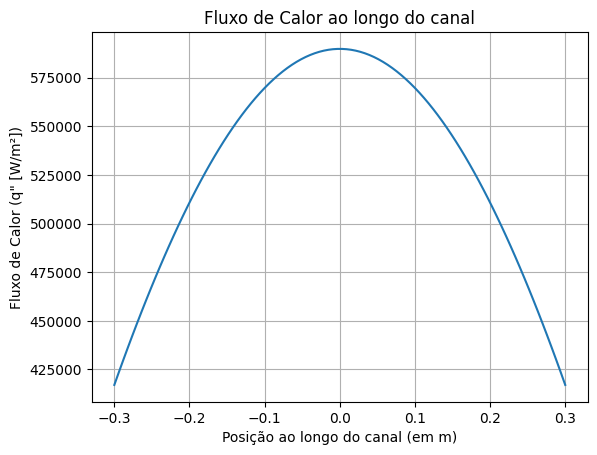

In [ ]:
from scipy.integrate import quad

def q_prime(x, qm, L):
    return qm * np.cos(np.pi/2 * x / L)

def calculate_heat_flux(qm, L, a, b):
    q_avg, _ = quad(q_prime, a, b, args=(qm, L))
    q_avg /= (b - a)
    return q_avg

# Parâmetros do sistema 
# EC = Elemento combustível
qm = q_prime_max # Fluxo de calor máximo na placa do EC com a maior taxa de transferência de calor
L = L_placa  # Comprimento total do canal em mm
a = -L/2  # Extremidade esquerda do canal
b = L/2   # Extremidade direita do canal

# Pontos ao longo do canal
x_values = np.linspace(a, b, 100)
q_values = q_prime(x_values, qm, L)

q_avg = calculate_heat_flux(qm, L, a, b)
print("Fluxo de calor médio no canal:", round(q_avg, 2), "W/m²")

# Plot do gráfico
plt.plot(x_values, q_values)
plt.xlabel('Posição ao longo do canal (em m)')
plt.ylabel('Fluxo de Calor (q" [W/m²])')
plt.title('Fluxo de Calor ao longo do canal')
plt.grid(True)
plt.show()

# Cálculo da condutividade térmica do combustível (kcomb).

```
# kcomb = [3978.1 / (692.61 +(T*(9/5)+32)) + ((6.02366*10**-12) * ((T*(9/5)+32) + 460) ** 3)] * 1.73073 
# 1 Btu/hr.ft.°F ≈ 1.73073 W/m·K
```
 Nessa função de correção da condutividade em função da temperatura do combustível (U3Si2-Al), T é a temperatura em graus Fahrenheit (°F) e o resultado da condutividade fornece o resultado da condutividade térmica em Btu/hr.ft.°F , que depois deverá ser convertido para W/m.K.

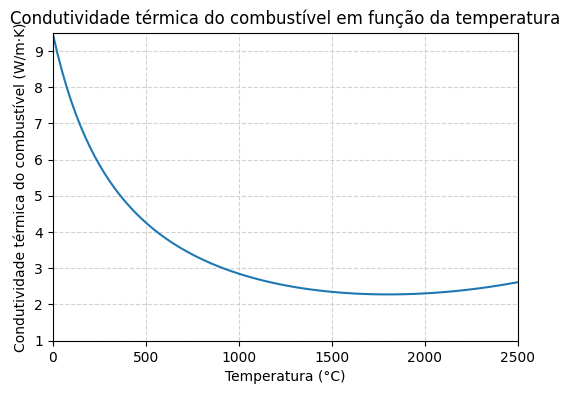

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definir faixa de temperatura em graus Celsius
temperatura = np.linspace(0, 2500, 100)  # Faixa de 0°C a 2500°C

# Converter temperatura para graus Fahrenheit
temperatura_fahrenheit = temperatura * 9/5 + 32

# Calcular a condutividade térmica do combustível (kcomb) em Btu/hr.ft.°F
kcomb_btu = (3978.1 / (692.61 + temperatura_fahrenheit)) + ((6.02366e-12) * (temperatura_fahrenheit + 460) ** 3)

# Converter a condutividade térmica de Btu/hr.ft.°F para W/m.K
kcomb = kcomb_btu * 1.73073

# Plotar o gráfico

plt.figure(figsize=(6, 4))
plt.plot(temperatura, kcomb)
plt.xlabel('Temperatura (°C)')
plt.ylabel('Condutividade térmica do combustível (W/m·K)')
plt.title('Condutividade térmica do combustível em função da temperatura')
plt.grid(True)
plt.xlim([0, 2500])
plt.ylim([min(kcomb), max(kcomb)])
plt.yticks(range(1, 10))
plt.gca().set_axisbelow(True)
plt.gca().xaxis.grid(color='lightgray', linestyle='--')
plt.gca().yaxis.grid(color='lightgray', linestyle='--')

plt.show()


# Resolução do conjunto de equações para a primeira camada.
A função Temp_cam é chamada dentro da função fsolve da biblioteca scipy.optimize para resolver um sistema de equações não lineares. Por fim, um loop for permite percorrer as posições ao longo do canal de aquecimento, atualizar a posição e calcular o novo valor de Q com base nas condições definidas pelas funções q_prime e pelos parâmetros do problema.

Temp 1 --> T_comb = 84.71 [°C]  T_rev= 74.18 [°C]  T_sup= 73.74 [°C]  T_fluido= 30.02 [°C]


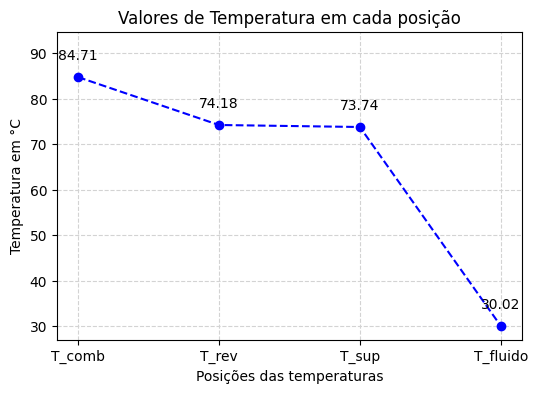

-----------------------------------------------------------------------


In [ ]:
Temp_cam = []
linha = []
Tlabel = [[], 4]
Xlabel = np.array(['T_comb','T_rev','T_sup','T_fluido'])
P_fluido = P_inlet

def Temp_cam(z, P_fluido):
  T_comb = z[0]
  T_rev = z[1]
  T_sup = z[2]
  T_fluido = z[3]
    
  # Cálculo da nova condutividade térmica do combustível (kcomb)
  kcomb_calc = (3978.1 / (692.61 +(z[0]*(9/5)+32)) + ((6.02366*10**-12) * ((z[0]*(9/5)+32) + 460) ** 3))*1.73073
  
  # Recálculo do coeficiente de transferência de calor por convecção (h)
  h = calculate_convection_coefficient((z[3]), [P_fluido], fluido, Dh, velocidade_canal)
  
  # Atualização das condutâncias
  Gcomb_i = kcomb_calc * Ax / Lcomb_i  # Condutância combustível-interface
  Gcomb_rev = (Gcomb_i * Grev_i) / (Gcomb_i + Grev_i) # Condutância combustível-revestimento
  Gcanal_sup = h * Ax # Condutância convectiva
  Gcanal = m_dot*cp # Condutância do fluido no canal
  Gcomb = kcomb_calc * Aycomb / dy # Condutância do combustível
  Grev = krev * Ayrev / dy # Condutância do revestimento

  F = np.empty((4))
  F[0] = Q + Gcomb_rev*(T_rev-T_comb)
  F[1] = Gcomb_rev*(T_comb-T_rev)+ Grev_sup*(T_sup-T_rev)
  F[2] = Grev_sup*(T_rev-T_sup) + Gcanal_sup*(T_fluido-T_sup)
  F[3] = Gcanal_sup*(T_sup-T_fluido) + Gcanal*(T_inlet-T_fluido)

  # Mostrar valores de kcomb e h em cada iteração
  #print("Valor de kcomb:", kcomb_calc)
  #print("Valor de h:", h)

  return F

z0 = np.array([1,1,1,1])
j = 0
for j in range(Ny+1):
  # Atualização da posição x
  x = (j - Ny/2) * dy
  # Atualização do valor de Q
  Q = q_prime(x, qm, L)*Ax
  z = fsolve(lambda z: Temp_cam(z, P_fluido), z0)
  P_fluido += deltaP
  linha.append(z)
print('Temp', 1, '-->', 'T_comb =', round(z[0], 2), '[°C]', ' T_rev=', round(z[1], 2), '[°C]', ' T_sup=', round(z[2], 2), '[°C]', ' T_fluido=', round(z[3], 2), '[°C]')

plt.figure(figsize=(6, 4))
plt.plot(Xlabel, z, 'bo--')
plt.xlabel('Posições das temperaturas')
plt.ylabel('Temperatura em °C')
plt.title('Valores de Temperatura em cada posição')
plt.grid(True)
plt.ylim([min(z)-3, max(z)+10])
plt.gca().set_axisbelow(True)
plt.gca().xaxis.grid(color='lightgray', linestyle='--')
plt.gca().yaxis.grid(color='lightgray', linestyle='--')
for i, valor in enumerate(z):
    plt.annotate(f'{valor:.2f}', (Xlabel[i], valor), textcoords="offset points", xytext=(0, 13), ha='center')

plt.show()
print('-----------------------------------------------------------------------')

j+=1

Temp 600 camadas --> T_comb = 94.15 [°C]  T_rev= 83.41 [°C]  T_sup= 82.97 [°C]  T_fluido= 43.61 [°C]


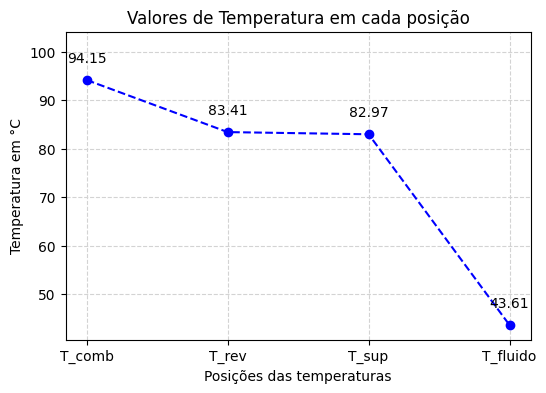

In [ ]:
Temp_cam_N = []
linha = []
Tlabel = [[], 4]
Xlabel = np.array(['T_comb','T_rev','T_sup','T_fluido'])
P_fluido = P_inlet

def Temp_cam_N(z, P_fluido):
  T_comb = z[0]
  T_rev = z[1]
  T_sup = z[2]
  T_fluido = z[3]
   # Cálculo da nova condutividade térmica do combustível (kcomb_calc)
  kcomb_calc = (3978.1 / (692.61 +(z[0]*(9/5)+32)) + ((6.02366*10**-12) * ((z[0]*(9/5)+32) + 460) ** 3))*1.73073
  #print(kcomb_calc)
  # Recálculo do coeficiente de transferência de calor por convecção (h)
  h = calculate_convection_coefficient((z[3]), [P_fluido], fluido, Dh, velocidade_canal)
  #print(h)  
  # Atualização das condutâncias
  Gcomb_i = kcomb_calc * Ax / Lcomb_i  # Condutância combustível-interface
  Gcomb_rev = (Gcomb_i * Grev_i) / (Gcomb_i + Grev_i) # Condutância combustível-revestimento
  Gcanal_sup = h * Ax # Condutância convectiva
  Gcanal = m_dot*cp # Condutância do fluido no canal
  Gcomb = kcomb_calc * Aycomb / dy # Condutância do combustível
  Grev = krev * Ayrev / dy # Condutância do revestimento

  F = np.empty((4))
  F[0] = Q + Gcomb_rev*(T_rev-T_comb) + Gcomb*(T_comb_a-T_comb)
  F[1] = Gcomb_rev*(T_comb-T_rev) + Grev*(T_rev_a-T_rev) + Grev_sup*(T_sup-T_rev)
  F[2] = Grev_sup*(T_rev-T_sup) + Gcanal_sup*(T_fluido-T_sup)
  F[3] = Gcanal_sup*(T_sup-T_fluido) +Gcanal*(T_fluido_a-T_fluido)
    
  return F

z0 = np.array([z[0], z[1], z[2], z[3]])
j = 0
for j in range(1,Ny+1):

  T_comb_a = z[0]
  T_rev_a = z[1]
  T_sup_a = z[2]
  T_fluido_a = z[3]

  # Atualização da posição x
  x = (j - Ny/2) * dy
  # Atualização do valor de Q
  Q = q_prime(x, qm, L)*Ax

  z = fsolve(lambda z: Temp_cam_N(z, P_fluido), z0)
  P_fluido += deltaP
  linha.append(z)
  #print('Posição da camada', x,'[m]', 'Fluxo de calor na posição x', Q,'[W]', 'Atualização da pressão do fluido por camada',P_fluido, '[Pa]') #Removendo o '#' dessa linha é possível verificar a atualização da posição, do fluxo de calor e da pressão ao longo do canal. 
print('Temp', j,'camadas -->','T_comb =', round (z[0],2),'[°C]', ' T_rev=', round(z[1],2),'[°C]',' T_sup=', round(z[2],2),'[°C]',' T_fluido=', round(z[3],2),'[°C]')

plt.figure(figsize=(6, 4))
plt.plot(Xlabel, z, 'bo--')
plt.xlabel('Posições das temperaturas')
plt.ylabel('Temperatura em °C')
plt.title('Valores de Temperatura em cada posição')
plt.grid(True)
plt.ylim([min(z)-3, max(z)+10])
plt.gca().set_axisbelow(True)
plt.gca().xaxis.grid(color='lightgray', linestyle='--')
plt.gca().yaxis.grid(color='lightgray', linestyle='--')
for i, valor in enumerate(z):
    plt.annotate(f'{valor:.2f}', (Xlabel[i], valor), textcoords="offset points", xytext=(0, 13), ha='center')

plt.show()

Xlabel = np.array(['T_comb','T_rev','T_sup','T_fluido'])
j+=1
